In [11]:
import numpy as np
import math
import matplotlib.pyplot as plt

import copy

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

In [2]:
X, y = make_classification(n_samples=500, n_features=4, n_informative=2, n_redundant=1,
                           n_repeated=0, n_classes=2, n_clusters_per_class=1, weights=None,
                           flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0,
                           shuffle=True, random_state=45)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

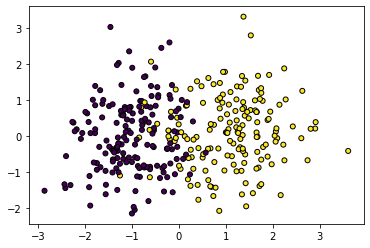

In [3]:
X_train = X_train[:, :2] 
X_test = X_test[:, :2] 

plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c=y_train,
            s=25, edgecolor='k')

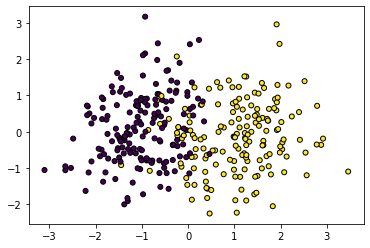

In [4]:
x_pca = PCA(n_components=2)
X_pca = x_pca.fit_transform(X_train)
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c=y_train,
            s=25, edgecolor='k')

***

In [13]:
def plot_learning_progress(x_val, y_real, y_pred, model=None, h=None,
                           theta=None, mse=0., epoch=0, fit_intercept=True):

    if fit_intercept:
        plot_ix_start = 1
        plot_ix_end = 2
    else:
        plot_ix_start = 0
        plot_ix_end = 1
        
    plt.figure(figsize=(8, 6))
    
    plt.scatter(x_val[:, plot_ix_start], x_val[:, plot_ix_end], marker='o', c=y_real,s=25, edgecolor='k')
    plt.legend()
    
    x1_min, x1_max = x_val[:,plot_ix_start].min(), x_val[:,plot_ix_start].max(),
    x2_min, x2_max = x_val[:,plot_ix_end].min(), x_val[:,plot_ix_end].max(),
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    #print(grid)
    
    probs = model.predict_prob(grid, h, ex_fit_intercept=fit_intercept).reshape(xx1.shape)
    
    plt.contour(xx1, xx2, probs, [0.5], linewidths=1, colors='black')

    plt.show()

In [5]:
class Activation(object):
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoidDerivative(self, x):
        return self.sigmoid(x) *  (1 - self.sigmoid(x))
    
    def softmax(self, z):
        z -= np.max(z)
        return np.exp(z) / np.sum(np.exp(z))

In [6]:
class HypotesisFunction(object):
    def __call__(self, x_val, theta):
        try:
            return x_val @ theta
        except Exception as ex:
            print(ex)
            print("x_val: {}".format(x_val))
            print("theta: {}".format(theta))

In [7]:
class NewtonRaphson(Activation):
    def __init__(self, epoch=100, theta=None , regularized=False, lambd=0.9):
        self.epoch = epoch
        self.theta = theta
        self.regularized = regularized
        self.lambd = lambd
    
    def initWeight(self, shape, mu=0, sigma=0.1):
        return np.random.normal(mu, sigma, shape)
    
    def fit(self, x_val, y_val):
        m, n = x_val.shape
        
        if self.theta is None:
            self.theta = self.initWeight(n)
            
        self.init_w = copy.copy(self.theta)
            
        for step in range(self.epoch):
            predictions = self.sigmoid(h(x_val, self.theta))
            
            R = np.diag(self.sigmoidDerivative(predictions))
            if self.regularized:
                # get identity matrix
                I = np.eye((n))
                
                H = (x_val.T @ R @ x_val) + self.lambd * I
            else:
                H = x_val.T @ R @ x_val
            Pinv = np.linalg.pinv(H)

            #z = x_val @ self.theta - np.linalg.inv(R) @ (y_val - predictions)
            #z = x_val @ self.theta - R @ (y_val - predictions)
            z = x_val @ self.theta - np.linalg.pinv(R) @ (y_val - predictions)
            
            self.theta -= Pinv @ x_val.T @ R @ z
        return self
            
    def predict_prob(self, x_val, hypo_function, ex_fit_intercept=False):
        if ex_fit_intercept:
            intercept = np.ones((x_val.shape[0], 1))
            x_val = np.concatenate((intercept, x_val), axis=1)

        return self.sigmoid(hypo_function(x_val, self.theta))
    
    def predict(self, x_val, hypo_function, is_round=True):
        if is_round:
            return self.predict_prob(x_val, hypo_function).round()
        else:
            return self.predict_prob(x_val, hypo_function)

In [8]:
m, n = X_train.shape
mt, nt = X_test.shape

bias_value = 1
X_ = np.hstack((np.full((m, 1), bias_value), X_train))
print(X_[:5, :])

_X_ = np.hstack((np.full((mt, 1), bias_value), X_test))
print(_X_[:5, :])

[[ 1.          2.9056038   0.21401172]
 [ 1.          0.15121623  0.84767329]
 [ 1.         -1.90304251 -1.10169355]
 [ 1.          1.30573883 -0.30548128]
 [ 1.          1.69966062 -0.86845398]]
[[ 1.         -2.35359326  0.3689328 ]
 [ 1.         -0.53809659 -2.27550073]
 [ 1.          0.95516023  0.82130863]
 [ 1.         -1.22523913  1.46799658]
 [ 1.          0.3335545  -1.47118521]]


In [9]:
h = HypotesisFunction()

No handles with labels found to put in legend.


[-0.0410589   0.22955461  0.02550328]
0.8909090909090909
[0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1.
 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.]
[0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0 1 0
 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0
 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0
 1 0 0 0 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1
 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 1]


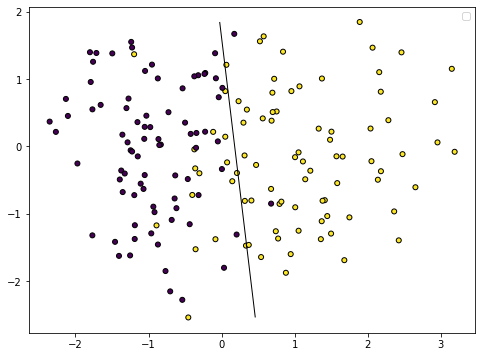

In [16]:
newtonlearn = NewtonRaphson(epoch=2, regularized=True, lambd=1000)
newt = newtonlearn.fit(X_,  y_train)

print(newt.theta)
preds = newt.predict(_X_, h)
print((preds == y_test).mean())
print(preds)
print(y_test)

plot_learning_progress(_X_, y_test, preds, newt, h, newt.theta, mse=0, epoch=100, fit_intercept=True)